In [8]:
# IMPORTS AND CONFIGURATION
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
TRAIN_DIR = 'training_set'
TEST_DIR = 'test_set'
TRAIN_CSV = 'training_set_pixel_size_and_HC.csv'
TEST_CSV = 'test_set_pixel_size.csv'
IMG_SIZE = 64 
print("Libraries imported and configuration set.")

Libraries imported and configuration set.


In [9]:
# HELPER FUNCTIONS
def visualize_sample(filename, folder_path):
    img_path = os.path.join(folder_path, filename)
    anno_filename = filename.replace('.png', '_Annotation.png')
    anno_path = os.path.join(folder_path, anno_filename)
    if os.path.exists(img_path) and os.path.exists(anno_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        anno = cv2.imread(anno_path, cv2.IMREAD_GRAYSCALE)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Original Image: {filename}')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(anno, cmap='gray')
        plt.title('Annotation Mask')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('DATA_LOADING_AND_EXPLORATION.png') 
        print("Saved plot to DATA_LOADING_AND_EXPLORATION.png")
        plt.show()
        print(f"Displayed sample: {filename}")
    else:
        print(f"Warning: Image or Annotation not found for {filename}")
def load_and_preprocess_data(df, folder_path, is_train=True):
    data_features = []
    targets = []
    filenames = []
    print(f"Processing data from: {folder_path}...")
    for index, row in df.iterrows():
        filename = row['filename']
        pixel_size = row['pixel size(mm)']
        img_path = os.path.join(folder_path, filename)
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            flat_img = img_resized.flatten()
            flat_img = flat_img / 255.0
            features = np.append(flat_img, pixel_size)
            data_features.append(features)
            filenames.append(filename)
            if is_train:
                targets.append(row['head circumference (mm)'])    
    X = np.array(data_features)
    y = np.array(targets) if is_train else None
    return X, y, filenames
print("Helper functions defined.")

Helper functions defined.


Loaded Training CSV. Shape: (999, 3)
Saved plot to DATA_LOADING_AND_EXPLORATION.png


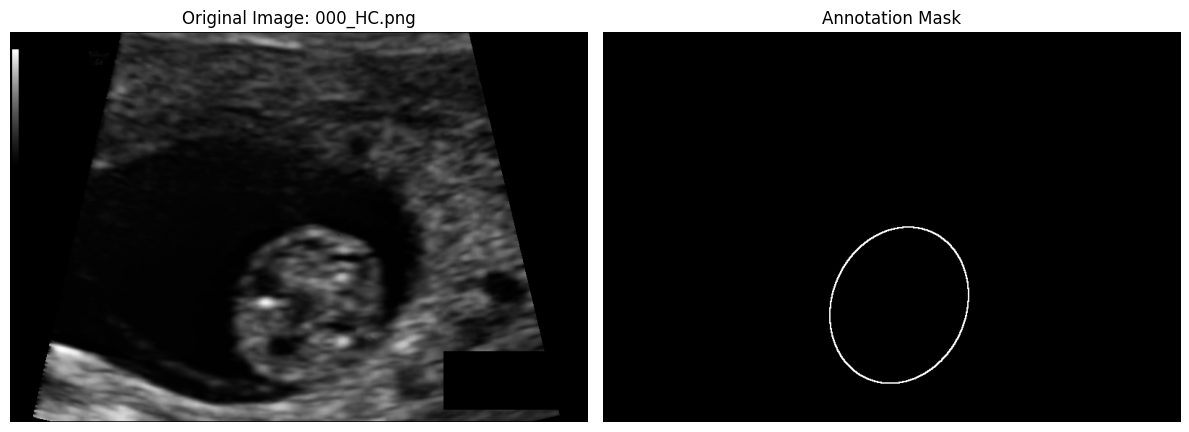

Displayed sample: 000_HC.png


In [10]:
# DATA LOADING AND EXPLORATION
if os.path.exists(TRAIN_CSV):
    train_df = pd.read_csv(TRAIN_CSV)
    print(f"Loaded Training CSV. Shape: {train_df.shape}")
    first_image_name = train_df.iloc[0]['filename']
    visualize_sample(first_image_name, TRAIN_DIR)
else:
    print(f"Error: {TRAIN_CSV} not found.")

In [11]:
# PREPARE TRAINING DATA
if 'train_df' in locals():
    X, y, _ = load_and_preprocess_data(train_df, TRAIN_DIR, is_train=True) 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data prepared.")
    print(f"Training set size: {X_train.shape}")
    print(f"Validation set size: {X_val.shape}")
else:
    print("Error: train_df is not defined. Please run Block 3 first.")

Processing data from: training_set...
Data prepared.
Training set size: (799, 4097)
Validation set size: (200, 4097)


In [12]:
# TRAIN MODEL
print("Training Random Forest Regressor.")
model = RandomForestRegressor(
    n_estimators=100,  
    max_depth=15,     
    n_jobs=-1,        
    random_state=42)
model.fit(X_train, y_train)
print("Training completed successfully.")

Training Random Forest Regressor.
Training completed successfully.


Model Evaluation Results:
Mean Absolute Error (MAE): 18.09 mm
Saved plot to EVALUATION.png


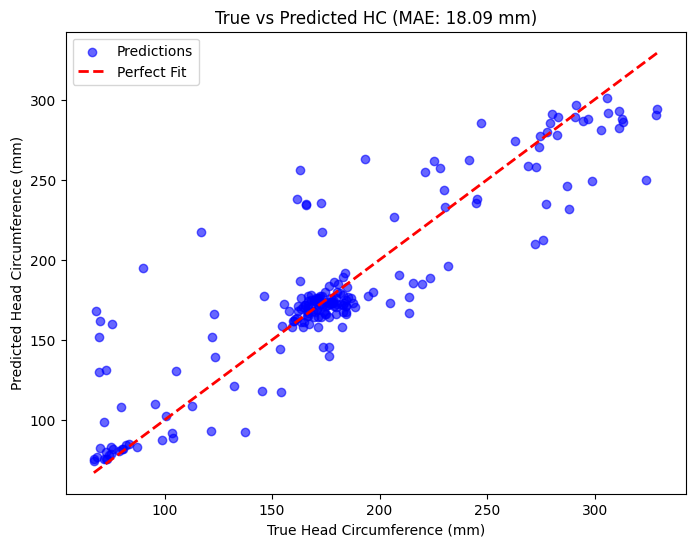

In [13]:
# EVALUATION
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"Model Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f} mm")
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6, color='blue', label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('True Head Circumference (mm)')
plt.ylabel('Predicted Head Circumference (mm)')
plt.title(f'True vs Predicted HC (MAE: {mae:.2f} mm)')
plt.legend()
plt.savefig('EVALUATION.png')
print("Saved plot to EVALUATION.png")
plt.show()

In [14]:
# INFERENCE ON TEST SET
if os.path.exists(TEST_CSV) and os.path.exists(TEST_DIR):
    print("Loading Test Data...")
    test_df = pd.read_csv(TEST_CSV)
    X_test, _, test_filenames = load_and_preprocess_data(test_df, TEST_DIR, is_train=False)
    if len(X_test) > 0:
        print("Generating predictions...")
        test_predictions = model.predict(X_test)
        submission = pd.DataFrame({
            'filename': test_filenames,
            'head circumference (mm)': test_predictions})
        output_filename = 'submission_results.csv'
        submission.to_csv(output_filename, index=False)
        print(f"Predictions saved to '{output_filename}'")
        print("First 5 predictions:")
        print(submission.head())
    else:
        print("No images found in the test set folder.")
else:
    print("Test CSV or Test Folder not found. Skipping inference.")

Loading Test Data...
Processing data from: test_set...
Generating predictions...
Predictions saved to 'submission_results.csv'
First 5 predictions:
     filename  head circumference (mm)
0  000_HC.png               284.724437
1  001_HC.png                75.410874
2  002_HC.png               190.941195
3  003_HC.png               109.537850
4  004_HC.png               294.752722
